In [1]:
import os
from tqdm import tqdm
import numpy as np
from datasets import load_dataset # huggingface datasets

num_proc = 8
num_proc_load_dataset = num_proc

/home/mainuser/anaconda3/envs/mintonano/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from transformers import AutoTokenizer
tokenizer = enc = AutoTokenizer.from_pretrained("tokenizer/tiny_stories_tokenizer")
tokenizer.pad_token = tokenizer.eos_token


In [3]:
tokenizer.vocab_size

6400

In [4]:
tinystories_ds = load_dataset("roneneldan/TinyStories")

#tinystories_ds.save_to_disk("data/tinystories")

Saving the dataset (1/1 shards): 100%|██████████| 21990/21990 [00:00<00:00, 817673.43 examples/s]


In [5]:
if __name__ == '__main__':
    # takes 54GB in huggingface .cache dir, about 8M documents (8,013,769)
    #dataset = load_dataset("data/tinystories", num_proc=num_proc_load_dataset)
    dataset = load_dataset("roneneldan/TinyStories", num_proc=num_proc_load_dataset)
    tokenizer.pad_token = eot= tokenizer.eos_token

In [6]:
tokenizer.encode(eot)

[0]

In [7]:
tokenizer.encode(' and')

[265]

In [8]:
tokenizer.decode([723])

'and'

In [9]:
tokenizer.encode(tokenizer.eos_token)[0]

0

In [10]:
dataset['train'][:10]

{'text': ['One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.',
  'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leav

In [11]:
def process(example):
    ids = tokenizer.encode(example['text']) # tiktoken doesn't have max seq length, HF does
    #ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    #ids = ids[:1023]
    #print(f"eos token is {tokenizer.encode(tokenizer.eos_token)}")
    ids.append(tokenizer.encode(tokenizer.eos_token)[0]) #token 1024
    #ids.append(enc.eot_token) # add the end of text token, e.g. 50256 for gpt2 bpe
    # note: I think eot should be prepended not appended... hmm. it's called "eot" though...
    out = {'ids': ids, 'len': len(ids)}
    return out

In [12]:
subs = dataset['train'].shuffle().select(range(10000)).map(process).to_pandas()

Map: 100%|██████████| 10000/10000 [00:02<00:00, 4053.18 examples/s]


In [13]:
print(subs.describe()); print(f"99.9th percentile with tokenizer of size {tokenizer.vocab_size}: {subs['len'].quantile(.999)}")

                len
count  10000.000000
mean     221.919600
std      107.799981
min        1.000000
25%      162.000000
50%      190.000000
75%      233.000000
max     1080.000000
99.9th percentile with tokenizer of size 6400: 853.0560000000114


In [35]:
print(subs.describe()); print(f"98th percentile with tokenizer of size {tokenizer.vocab_size}: {subs['len'].quantile(.9675)}")

                len
count  10000.000000
mean     221.919600
std      107.799981
min        1.000000
25%      162.000000
50%      190.000000
75%      233.000000
max     1080.000000
98th percentile with tokenizer of size 6400: 512.0


In [14]:
subs.head()

,text,ids,len
0,Sara liked to dream. She dreamed of many thing...,"[1163, 615, 266, 1424, 14, 313, 3099, 347, 790...",355
1,Once upon a time there was a small dog called ...,"[431, 447, 259, 396, 399, 282, 259, 795, 634, ...",168
2,"One day, a zebra named Zara was walking in the...","[420, 356, 12, 259, 3457, 500, 2692, 625, 282,...",156
3,"Once upon a time, there was a brave knight nam...","[431, 447, 259, 396, 12, 399, 282, 259, 921, 2...",220
4,Once there was a little girl who was eager to ...,"[431, 399, 282, 259, 397, 446, 592, 282, 2867,...",171


In [15]:
mx=subs['len'].max()
mx

1080

In [16]:
longest=subs[subs.len==mx]['text']

In [17]:
subs[subs.len==mx]['ids'].values[0]

array([ 980,  265,  839, ...,    2, 1666,    0])

In [18]:
tokenizer.decode(subs[subs.len==mx]['ids'].values[0])

'Ben and Mia were at the beach with their mom and dad. They saw a big boat with many people on it. The people had nets and hooks. They wanted to catch the dolphins that lived in the water.\n\n"Look, mom, dolphins!" Ben said, pointing at the shiny gray animals that jumped and played in the waves.\n\n"Yes, they are beautiful, aren\'t they?" mom said, smiling. "But we have to be careful. Some people are selfish and want to hurt them."\n\n"Why?" Mia asked, frowning. "Dolphins are nice and smart. They are our friends."\n\n"Some people don\'t care about that. They only want to make money or have fun. They don\'t think about how the dolphins feel." mom said, sadly.\n\nSuddenly, they heard a loud splash and a cry. One of the dolphins was caught in a net. The people on the boat were pulling it up. The dolphin was scared and hurt. It tried to wiggle and escape, but it couldn\'t.\n\n"Help, help!" the dolphin said, in a way that only dolphins and some children can understand.\n\nBen and Mia heard 

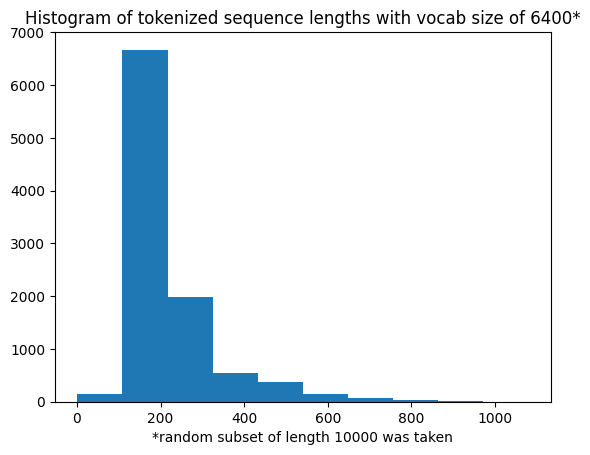

In [19]:
hst=subs['len'].hist()
hst.set_title(f'Histogram of tokenized sequence lengths with vocab size of {tokenizer.vocab_size}*')
hst.set_xlabel("*random subset of length 10000 was taken")
hst.grid(False)

In [20]:
longest.values[0]

'Ben and Mia were at the beach with their mom and dad. They saw a big boat with many people on it. The people had nets and hooks. They wanted to catch the dolphins that lived in the water.\n\n"Look, mom, dolphins!" Ben said, pointing at the shiny gray animals that jumped and played in the waves.\n\n"Yes, they are beautiful, aren\'t they?" mom said, smiling. "But we have to be careful. Some people are selfish and want to hurt them."\n\n"Why?" Mia asked, frowning. "Dolphins are nice and smart. They are our friends."\n\n"Some people don\'t care about that. They only want to make money or have fun. They don\'t think about how the dolphins feel." mom said, sadly.\n\nSuddenly, they heard a loud splash and a cry. One of the dolphins was caught in a net. The people on the boat were pulling it up. The dolphin was scared and hurt. It tried to wiggle and escape, but it couldn\'t.\n\n"Help, help!" the dolphin said, in a way that only dolphins and some children can understand.\n\nBen and Mia heard 

In [21]:
assert tokenizer.decode(tokenizer.encode(subs.loc[0,['text']].values[0])) == subs.loc[0,['text']].values[0], 'tokenization does not match'

In [22]:
subs.loc[1000,['text']].values[0] # in original dataset

'Once upon a time, there was a little girl named Lily. She loved to play with her fancy dolls and her favorite stick. One day, Lily was playing in the park when she saw a boy riding his bike. The boy accidentally rode into a tree and fell off his bike.\n\nLily ran over to the boy and asked, "Are you okay?" The boy said, "No, my bike is broken. I need to reverse the pedals." Lily didn\'t know what "reverse" meant, so the boy explained that he needed to turn the pedals backwards to fix his bike.\n\nLily wanted to help, so she took her stick and tried to reverse the pedals. It didn\'t work, so the boy showed her how to do it. When they fixed the bike, the boy said, "Thank you for helping me. You are very kind." Lily felt happy and proud that she could help someone. She went home and told her mom about her adventure in the park.'

In [23]:
assert tokenizer.decode(tokenizer.encode(subs.loc[1000,['text']].values[0])) == subs.loc[1000,['text']].values[0], 'tokenization does not match'

In [24]:
tokens=tokenizer.encode("Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat.")

In [25]:
import torch
device = 'cuda:0'
num_return_sequences = 4
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)

In [26]:
xgen

tensor([[ 431,  447,  259,  396,  399,  282,  259, 2868, 1101,  592, 1418,  263,
         1074,  266,  652,  366,  565, 1440,  266,  762,   14],
        [ 431,  447,  259,  396,  399,  282,  259, 2868, 1101,  592, 1418,  263,
         1074,  266,  652,  366,  565, 1440,  266,  762,   14],
        [ 431,  447,  259,  396,  399,  282,  259, 2868, 1101,  592, 1418,  263,
         1074,  266,  652,  366,  565, 1440,  266,  762,   14],
        [ 431,  447,  259,  396,  399,  282,  259, 2868, 1101,  592, 1418,  263,
         1074,  266,  652,  366,  565, 1440,  266,  762,   14]],
       device='cuda:0')

In [27]:
xgen.size()

torch.Size([4, 21])